## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth (m)", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    yticks_ix = np.array(ax[0].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[0].set_yticklabels(depth_label, rotation=0)
    ax[0].collections[0].colorbar.set_label("Actual Temperature ($^\circ$C)")

    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax[1].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[1].set_yticklabels(depth_label, rotation=0)
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    yticks_ix = np.array(ax[2].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[2].set_yticklabels(depth_label, rotation=0)
    ax[2].collections[0].colorbar.set_label("Absolute Error ($^\circ$C)")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")



RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 0.07817939
RMSE of after m4 0.07870821
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 0.1477848
RMSE of after m4 0.14640383
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 0.089379124
RMSE of after m4 0.09203076
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 0.090026364
RMSE of after m4 0.09087419
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 0.01690196
RMSE of after m4 0.017224463
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 0.011024926
RMSE of after m4 0.011710198
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 0.009375972
RMSE of after m4 0.009957707
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 0.010425117
RMSE of after m4 0.010811509
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 0.0113804

RMSE of after m1 0.01914478
RMSE of after m3 0.022819554
RMSE of after m4 0.02123006
RMSE of after m0 0.018019704
RMSE of after m1 0.023479847
RMSE of after m3 0.025513444
RMSE of after m4 0.023874393
RMSE of after m0 0.015118729
RMSE of after m1 0.023506418
RMSE of after m3 0.18972333
RMSE of after m4 0.18658829
RMSE of after m0 0.007792614
RMSE of after m1 0.008576836
RMSE of after m3 0.026381249
RMSE of after m4 0.0243727
RMSE of after m0 0.009526869
RMSE of after m1 0.010083725
RMSE of after m3 0.0421065
RMSE of after m4 0.046019692
RMSE of after m0 0.009393042
RMSE of after m1 0.011325409
RMSE of after m3 0.030858874
RMSE of after m4 0.029808799
RMSE of after m0 0.010285034
RMSE of after m1 0.013249002
RMSE of after m3 0.06625607
RMSE of after m4 0.065137625
RMSE of after m0 0.009125734
RMSE of after m1 0.0137356585
RMSE of after m3 0.033011626
RMSE of after m4 0.037946906
RMSE of after m0 0.008596247
RMSE of after m1 0.014596719
RMSE of after m3 0.036350157
RMSE of after m4 0.041

RMSE of after m1 0.010321087
RMSE of after m3 0.021522813
RMSE of after m4 0.023335833
RMSE of after m0 0.009089295
RMSE of after m1 0.010631722
RMSE of after m3 0.037587266
RMSE of after m4 0.026897464
RMSE of after m0 0.00799167
RMSE of after m1 0.010626613
RMSE of after m3 0.034133535
RMSE of after m4 0.031654857
RMSE of after m0 0.008825115
RMSE of after m1 0.013106328
RMSE of after m3 0.04016873
RMSE of after m4 0.042071603
RMSE of after m0 0.010953018
RMSE of after m1 0.015220422
RMSE of after m3 0.039383784
RMSE of after m4 0.047437284
RMSE of after m0 0.009173058
RMSE of after m1 0.014213214
RMSE of after m3 0.025673259
RMSE of after m4 0.036150508
RMSE of after m0 0.010232818
RMSE of after m1 0.011256004
RMSE of after m3 0.05194099
RMSE of after m4 0.048384815
RMSE of after m0 0.008506172
RMSE of after m1 0.010823727
RMSE of after m3 0.02390817
RMSE of after m4 0.021520633
RMSE of after m0 0.008689203
RMSE of after m1 0.0121498145
RMSE of after m3 0.027968938
RMSE of after m4 

RMSE of after m3 0.029692104
RMSE of after m4 0.034536697
RMSE of after m0 0.010214393
RMSE of after m1 0.021390636
RMSE of after m3 0.024043195
RMSE of after m4 0.03147781
RMSE of after m0 0.0099554155
RMSE of after m1 0.020566091
RMSE of after m3 0.01790916
RMSE of after m4 0.025006099
RMSE of after m0 0.01041229
RMSE of after m1 0.018725535
RMSE of after m3 0.03287021
RMSE of after m4 0.036375336
RMSE of after m0 0.010821615
RMSE of after m1 0.020351026
RMSE of after m3 0.024815105
RMSE of after m4 0.032451395
RMSE of after m0 0.012248541
RMSE of after m1 0.022432296
RMSE of after m3 0.024429271
RMSE of after m4 0.03613149
RMSE of after m0 0.012491177
RMSE of after m1 0.023117758
RMSE of after m3 0.021450786
RMSE of after m4 0.028104812
RMSE of after m0 0.011968924
RMSE of after m1 0.02403254
RMSE of after m3 0.023090389
RMSE of after m4 0.032458317
RMSE of after m0 0.011566487
RMSE of after m1 0.023139948
RMSE of after m3 0.032411862
RMSE of after m4 0.040391672
RMSE of after m0 0.

RMSE of after m0 0.006422394
RMSE of after m1 0.007721748
RMSE of after m3 0.027100513
RMSE of after m4 0.02654893
RMSE of after m0 0.007968254
RMSE of after m1 0.006812382
RMSE of after m3 0.026406849
RMSE of after m4 0.02345778
RMSE of after m0 0.007429157
RMSE of after m1 0.0072827237
RMSE of after m3 0.01908621
RMSE of after m4 0.022812173
RMSE of after m0 0.0068837213
RMSE of after m1 0.008430453
RMSE of after m3 0.028212644
RMSE of after m4 0.024347637
RMSE of after m0 0.0070486306
RMSE of after m1 0.0096371155
RMSE of after m3 0.034652855
RMSE of after m4 0.034708682
RMSE of after m0 0.0059876433
RMSE of after m1 0.008764446
RMSE of after m3 0.021205898
RMSE of after m4 0.022173036
RMSE of after m0 0.00649155
RMSE of after m1 0.008171711
RMSE of after m3 0.019258695
RMSE of after m4 0.021106685
RMSE of after m0 0.0069554397
RMSE of after m1 0.0079555
RMSE of after m3 0.023742296
RMSE of after m4 0.026360624
RMSE of after m0 0.006981749
RMSE of after m1 0.008129739
RMSE of after 

RMSE of after m1 0.015245948
RMSE of after m3 0.01601066
RMSE of after m4 0.015800625
RMSE of after m0 0.019109152
RMSE of after m1 0.018493395
RMSE of after m3 0.018319098
RMSE of after m4 0.01798488
RMSE of after m0 0.017577264
RMSE of after m1 0.016452542
RMSE of after m3 0.01417358
RMSE of after m4 0.013664811
RMSE of after m0 0.01599474
RMSE of after m1 0.014127926
RMSE of after m3 0.015493753
RMSE of after m4 0.014809786
RMSE of after m0 0.0167539
RMSE of after m1 0.01512995
RMSE of after m3 0.017114084
RMSE of after m4 0.016354812
RMSE of after m0 0.01728295
RMSE of after m1 0.017737217
RMSE of after m3 0.018183304
RMSE of after m4 0.017309196
RMSE of after m0 0.016834516
RMSE of after m1 0.014388266
RMSE of after m3 0.015045528
RMSE of after m4 0.014423197
RMSE of after m0 0.017702194
RMSE of after m1 0.015151337
RMSE of after m3 0.016394421
RMSE of after m4 0.015969705
RMSE of after m0 0.01889585
RMSE of after m1 0.017317543
RMSE of after m3 0.017893804
RMSE of after m4 0.0172

RMSE of after m1 0.023220096
RMSE of after m3 0.018281303
RMSE of after m4 0.01650339
RMSE of after m0 0.022572609
RMSE of after m1 0.021175658
RMSE of after m3 0.015980491
RMSE of after m4 0.013958144
RMSE of after m0 0.025094327
RMSE of after m1 0.020449892
RMSE of after m3 0.016119236
RMSE of after m4 0.015103031
RMSE of after m0 0.02589228
RMSE of after m1 0.021323912
RMSE of after m3 0.014305178
RMSE of after m4 0.012922661
RMSE of after m0 0.02469893
RMSE of after m1 0.019358888
RMSE of after m3 0.014235133
RMSE of after m4 0.012318154
RMSE of after m0 0.022686914
RMSE of after m1 0.017330043
RMSE of after m3 0.018441465
RMSE of after m4 0.018331755
RMSE of after m0 0.02406953
RMSE of after m1 0.018381488
RMSE of after m3 0.01980489
RMSE of after m4 0.019242862
RMSE of after m0 0.02370774
RMSE of after m1 0.01986879
RMSE of after m3 0.015676923
RMSE of after m4 0.014157801
RMSE of after m0 0.024337156
RMSE of after m1 0.02069449
RMSE of after m3 0.017425988
RMSE of after m4 0.015

RMSE of after m1 0.028725972
RMSE of after m3 0.024376543
RMSE of after m4 0.023578634
RMSE of after m0 0.020511664
RMSE of after m1 0.024848567
RMSE of after m3 0.018155012
RMSE of after m4 0.017450966
RMSE of after m0 0.020195277
RMSE of after m1 0.025379164
RMSE of after m3 0.01942106
RMSE of after m4 0.0186
RMSE of after m0 0.022634923
RMSE of after m1 0.025090594
RMSE of after m3 0.020401262
RMSE of after m4 0.020519393
RMSE of after m0 0.023902705
RMSE of after m1 0.027353782
RMSE of after m3 0.017933736
RMSE of after m4 0.018992951
RMSE of after m0 0.022990946
RMSE of after m1 0.024866821
RMSE of after m3 0.020521758
RMSE of after m4 0.022597307
RMSE of after m0 0.019450672
RMSE of after m1 0.0248246
RMSE of after m3 0.02120715
RMSE of after m4 0.022802051
RMSE of after m0 0.018526468
RMSE of after m1 0.025548445
RMSE of after m3 0.02017555
RMSE of after m4 0.022132074
RMSE of after m0 0.018734073
RMSE of after m1 0.023045748
RMSE of after m3 0.018404743
RMSE of after m4 0.02033

RMSE of after m4 0.028957447
RMSE of after m0 0.009271784
RMSE of after m1 0.015847526
RMSE of after m3 0.029337684
RMSE of after m4 0.03592926
RMSE of after m0 0.007895335
RMSE of after m1 0.015502597
RMSE of after m3 0.01778939
RMSE of after m4 0.023253206
RMSE of after m0 0.008718764
RMSE of after m1 0.013475934
RMSE of after m3 0.01552075
RMSE of after m4 0.022237215
RMSE of after m0 0.009209134
RMSE of after m1 0.015218137
RMSE of after m3 0.023077901
RMSE of after m4 0.030291015
RMSE of after m0 0.010445049
RMSE of after m1 0.016766142
RMSE of after m3 0.027580384
RMSE of after m4 0.035748813
RMSE of after m0 0.011175525
RMSE of after m1 0.0183395
RMSE of after m3 0.02500103
RMSE of after m4 0.037518688
RMSE of after m0 0.010715699
RMSE of after m1 0.019210465
RMSE of after m3 0.019146571
RMSE of after m4 0.031458605
RMSE of after m0 0.011205905
RMSE of after m1 0.020935385
RMSE of after m3 0.023146534
RMSE of after m4 0.036376286
RMSE of after m0 0.008712079
RMSE of after m1 0.0

RMSE of after m1 0.020353252
RMSE of after m3 0.020501146
RMSE of after m4 0.03781632
RMSE of after m0 0.013497827
RMSE of after m1 0.02352546
RMSE of after m3 0.032959975
RMSE of after m4 0.050155137
RMSE of after m0 0.009999872
RMSE of after m1 0.020598628
RMSE of after m3 0.021143666
RMSE of after m4 0.033715297
RMSE of after m0 0.008178362
RMSE of after m1 0.017750358
RMSE of after m3 0.018237468
RMSE of after m4 0.030115694
RMSE of after m0 0.009436904
RMSE of after m1 0.015698677
RMSE of after m3 0.08419114
RMSE of after m4 0.080612674
RMSE of after m0 0.009828801
RMSE of after m1 0.013874234
RMSE of after m3 0.0576197
RMSE of after m4 0.041852564
RMSE of after m0 0.010338609
RMSE of after m1 0.01499232
RMSE of after m3 0.056176133
RMSE of after m4 0.037524052
RMSE of after m0 0.008694731
RMSE of after m1 0.01591312
RMSE of after m3 0.03048249
RMSE of after m4 0.032130904
RMSE of after m0 0.008116029
RMSE of after m1 0.016168248
RMSE of after m3 0.030075355
RMSE of after m4 0.035

RMSE of after m0 0.011167895
RMSE of after m1 0.012476995
RMSE of after m3 0.093779355
RMSE of after m4 0.08669173
RMSE of after m0 0.011380513
RMSE of after m1 0.015826076
RMSE of after m3 0.2688207
RMSE of after m4 0.27016503
RMSE of after m0 0.01146917
RMSE of after m1 0.013841483
RMSE of after m3 0.30307183
RMSE of after m4 0.3032182
RMSE of after m0 0.013327791
RMSE of after m1 0.013801357
RMSE of after m3 0.20043556
RMSE of after m4 0.20110835
RMSE of after m0 0.013692015
RMSE of after m1 0.013532871
RMSE of after m3 0.05253506
RMSE of after m4 0.05297311
RMSE of after m0 0.0191295
RMSE of after m1 0.04187701
RMSE of after m3 0.12845632
RMSE of after m4 0.12690666
RMSE of after m0 0.020640511
RMSE of after m1 0.02215235
RMSE of after m3 0.019573284
RMSE of after m4 0.018534742
RMSE of after m0 0.019077087
RMSE of after m1 0.023451801
RMSE of after m3 0.056970436
RMSE of after m4 0.05705957
RMSE of after m0 0.018258227
RMSE of after m1 0.023911817
RMSE of after m3 0.024058726
RMSE

RMSE of after m4 0.015182179
RMSE of after m0 0.023944853
RMSE of after m1 0.019528303
RMSE of after m3 0.0170462
RMSE of after m4 0.015271944
RMSE of after m0 0.027259607
RMSE of after m1 0.019545536
RMSE of after m3 0.017143914
RMSE of after m4 0.016167967
RMSE of after m0 0.027740084
RMSE of after m1 0.02067594
RMSE of after m3 0.018360186
RMSE of after m4 0.016989522
RMSE of after m0 0.024884403
RMSE of after m1 0.0183422
RMSE of after m3 0.019390838
RMSE of after m4 0.01762564
RMSE of after m0 0.0272878
RMSE of after m1 0.018947039
RMSE of after m3 0.019551652
RMSE of after m4 0.017507346
RMSE of after m0 0.027585255
RMSE of after m1 0.020034244
RMSE of after m3 0.016188584
RMSE of after m4 0.014457736
RMSE of after m0 0.027619736
RMSE of after m1 0.02122468
RMSE of after m3 0.018684924
RMSE of after m4 0.016947145
RMSE of after m0 0.02515775
RMSE of after m1 0.01919741
RMSE of after m3 0.016348982
RMSE of after m4 0.014484918
RMSE of after m0 0.028664863
RMSE of after m1 0.020475

RMSE of after m3 0.027604306
RMSE of after m4 0.027149547
RMSE of after m0 0.023984177
RMSE of after m1 0.027866792
RMSE of after m3 0.02226819
RMSE of after m4 0.021829467
RMSE of after m0 0.022104379
RMSE of after m1 0.02538078
RMSE of after m3 0.03876078
RMSE of after m4 0.0373216
RMSE of after m0 0.024291983
RMSE of after m1 0.024180649
RMSE of after m3 0.021005094
RMSE of after m4 0.019581627
RMSE of after m0 0.023605892
RMSE of after m1 0.024304453
RMSE of after m3 0.020018652
RMSE of after m4 0.0189471
RMSE of after m0 0.02323521
RMSE of after m1 0.02120319
RMSE of after m3 0.018448222
RMSE of after m4 0.017509345
RMSE of after m0 0.02437774
RMSE of after m1 0.022093901
RMSE of after m3 0.016969359
RMSE of after m4 0.016097985
RMSE of after m0 0.025029343
RMSE of after m1 0.025048964
RMSE of after m3 0.019441642
RMSE of after m4 0.018502643
RMSE of after m0 0.023932263
RMSE of after m1 0.024808506
RMSE of after m3 0.023053793
RMSE of after m4 0.021720638
RMSE of after m0 0.02235

RMSE of after m0 0.00971283
RMSE of after m1 0.016025873
RMSE of after m3 0.019877842
RMSE of after m4 0.026490264
RMSE of after m0 0.010246257
RMSE of after m1 0.018043391
RMSE of after m3 0.022541333
RMSE of after m4 0.02959323
RMSE of after m0 0.0074016387
RMSE of after m1 0.014884982
RMSE of after m3 0.016224913
RMSE of after m4 0.019682009
RMSE of after m0 0.00854837
RMSE of after m1 0.010388079
RMSE of after m3 0.05246943
RMSE of after m4 0.046112433
RMSE of after m0 0.008256472
RMSE of after m1 0.012288646
RMSE of after m3 0.01741711
RMSE of after m4 0.021035323
RMSE of after m0 0.008875197
RMSE of after m1 0.012863783
RMSE of after m3 0.019205589
RMSE of after m4 0.02143973
RMSE of after m0 0.008492482
RMSE of after m1 0.013963609
RMSE of after m3 0.011478143
RMSE of after m4 0.021471452
RMSE of after m0 0.008415137
RMSE of after m1 0.015090479
RMSE of after m3 0.014700949
RMSE of after m4 0.023841523
RMSE of after m0 0.0074458914
RMSE of after m1 0.013671438
RMSE of after m3 0

RMSE of after m4 0.020513495
RMSE of after m0 0.009727703
RMSE of after m1 0.01734801
RMSE of after m3 0.014480992
RMSE of after m4 0.023786064
RMSE of after m0 0.008868498
RMSE of after m1 0.013913997
RMSE of after m3 0.03477939
RMSE of after m4 0.032013938
RMSE of after m0 0.009588532
RMSE of after m1 0.014917261
RMSE of after m3 0.027875144
RMSE of after m4 0.030653149
RMSE of after m0 0.011000832
RMSE of after m1 0.01743882
RMSE of after m3 0.022920942
RMSE of after m4 0.029113386
RMSE of after m0 0.010762428
RMSE of after m1 0.017549107
RMSE of after m3 0.021545818
RMSE of after m4 0.027327856
RMSE of after m0 0.011391121
RMSE of after m1 0.019634794
RMSE of after m3 0.016474605
RMSE of after m4 0.026510108
RMSE of after m0 0.009549014
RMSE of after m1 0.018027378
RMSE of after m3 0.017847046
RMSE of after m4 0.029998844
RMSE of after m0 0.008508215
RMSE of after m1 0.013301546
RMSE of after m3 0.038416922
RMSE of after m4 0.036523283
RMSE of after m0 0.009516381
RMSE of after m1 

RMSE of after m1 0.005099587
RMSE of after m3 0.026071886
RMSE of after m4 0.02452249
RMSE of after m0 0.007373207
RMSE of after m1 0.0067554917
RMSE of after m3 0.046606023
RMSE of after m4 0.03825774
RMSE of after m0 0.0069041746
RMSE of after m1 0.006146404
RMSE of after m3 0.060414992
RMSE of after m4 0.0466995
RMSE of after m0 0.0076507805
RMSE of after m1 0.0077789095
RMSE of after m3 0.053480096
RMSE of after m4 0.047186878
RMSE of after m0 0.006787697
RMSE of after m1 0.0071171187
RMSE of after m3 0.05624582
RMSE of after m4 0.05182745
RMSE of after m0 0.0067270887
RMSE of after m1 0.0062141707
RMSE of after m3 0.03418647
RMSE of after m4 0.027721245
RMSE of after m0 0.008059494
RMSE of after m1 0.0076419567
RMSE of after m3 0.042560212
RMSE of after m4 0.03366601
RMSE of after m0 0.008592491
RMSE of after m1 0.009060493
RMSE of after m3 0.061500926
RMSE of after m4 0.054937128
RMSE of after m0 0.009398196
RMSE of after m1 0.0111286715
RMSE of after m3 0.1565145
RMSE of after m

RMSE of after m1 0.026017344
RMSE of after m3 0.014264643
RMSE of after m4 0.011568754
RMSE of after m0 0.01986189
RMSE of after m1 0.024613153
RMSE of after m3 0.014454342
RMSE of after m4 0.011778381
RMSE of after m0 0.018652314
RMSE of after m1 0.021977425
RMSE of after m3 0.013011227
RMSE of after m4 0.010477375
RMSE of after m0 0.018279435
RMSE of after m1 0.021166587
RMSE of after m3 0.011360613
RMSE of after m4 0.008991969
RMSE of after m0 0.01774008
RMSE of after m1 0.020311048
RMSE of after m3 0.0134992115
RMSE of after m4 0.011304541
RMSE of after m0 0.017684061
RMSE of after m1 0.019533742
RMSE of after m3 0.030330537
RMSE of after m4 0.029694788
RMSE of after m0 0.02064683
RMSE of after m1 0.01890124
RMSE of after m3 0.036930304
RMSE of after m4 0.036612753
RMSE of after m0 0.021812472
RMSE of after m1 0.020571701
RMSE of after m3 0.011602788
RMSE of after m4 0.009753898
RMSE of after m0 0.020847814
RMSE of after m1 0.02002808
RMSE of after m3 0.0104602035
RMSE of after m4 

RMSE of after m0 0.027904281
RMSE of after m1 0.0247308
RMSE of after m3 0.027092516
RMSE of after m4 0.024911847
RMSE of after m0 0.030561034
RMSE of after m1 0.023299567
RMSE of after m3 0.033407032
RMSE of after m4 0.032743998
RMSE of after m0 0.029774321
RMSE of after m1 0.02466321
RMSE of after m3 0.020521803
RMSE of after m4 0.01804268
RMSE of after m0 0.030856065
RMSE of after m1 0.025490701
RMSE of after m3 0.02254959
RMSE of after m4 0.01979999
RMSE of after m0 0.028384335
RMSE of after m1 0.02408587
RMSE of after m3 0.026652912
RMSE of after m4 0.024021694
RMSE of after m0 0.02700452
RMSE of after m1 0.023352064
RMSE of after m3 0.026158066
RMSE of after m4 0.023684038
RMSE of after m0 0.02666516
RMSE of after m1 0.02459553
RMSE of after m3 0.02326994
RMSE of after m4 0.020251498
RMSE of after m0 0.02633718
RMSE of after m1 0.020983888
RMSE of after m3 0.018899428
RMSE of after m4 0.017222598
RMSE of after m0 0.030986099
RMSE of after m1 0.024692822
RMSE of after m3 0.0172195

RMSE of after m1 0.008659399
RMSE of after m3 0.03581426
RMSE of after m4 0.030517794
RMSE of after m0 0.011287614
RMSE of after m1 0.01266173
RMSE of after m3 0.045233905
RMSE of after m4 0.047118735
RMSE of after m0 0.007156989
RMSE of after m1 0.009487705
RMSE of after m3 0.01998784
RMSE of after m4 0.024280114
RMSE of after m0 0.008712894
RMSE of after m1 0.0101277055
RMSE of after m3 0.040051028
RMSE of after m4 0.038299527
RMSE of after m0 0.008593865
RMSE of after m1 0.009392871
RMSE of after m3 0.03741325
RMSE of after m4 0.034335975
RMSE of after m0 0.009139388
RMSE of after m1 0.0126653155
RMSE of after m3 0.028792776
RMSE of after m4 0.033582553
RMSE of after m0 0.009545473
RMSE of after m1 0.015321811
RMSE of after m3 0.027216494
RMSE of after m4 0.034584835
RMSE of after m0 0.007409542
RMSE of after m1 0.0117830625
RMSE of after m3 0.012466837
RMSE of after m4 0.022510355
RMSE of after m0 0.00862072
RMSE of after m1 0.010869337
RMSE of after m3 0.01607155
RMSE of after m4 

RMSE of after m1 0.017462742
RMSE of after m3 0.02592267
RMSE of after m4 0.030183293
RMSE of after m0 0.009762967
RMSE of after m1 0.017132103
RMSE of after m3 0.036228947
RMSE of after m4 0.03475574
RMSE of after m0 0.009453419
RMSE of after m1 0.018085957
RMSE of after m3 0.034350965
RMSE of after m4 0.039656393
RMSE of after m0 0.009871322
RMSE of after m1 0.018373964
RMSE of after m3 0.027345188
RMSE of after m4 0.036180764
RMSE of after m0 0.011147794
RMSE of after m1 0.020083806
RMSE of after m3 0.06809316
RMSE of after m4 0.078558125
RMSE of after m0 0.010477424
RMSE of after m1 0.019526131
RMSE of after m3 0.023640787
RMSE of after m4 0.034379892
RMSE of after m0 0.010409474
RMSE of after m1 0.017313814
RMSE of after m3 0.03931705
RMSE of after m4 0.03793368
RMSE of after m0 0.010692715
RMSE of after m1 0.01928576
RMSE of after m3 0.035779484
RMSE of after m4 0.04004895
RMSE of after m0 0.008693203
RMSE of after m1 0.016968424
RMSE of after m3 0.028339911
RMSE of after m4 0.03

In [23]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)

(1577100, 45)
(1051450, 45)
torch.Size([1577100, 1])


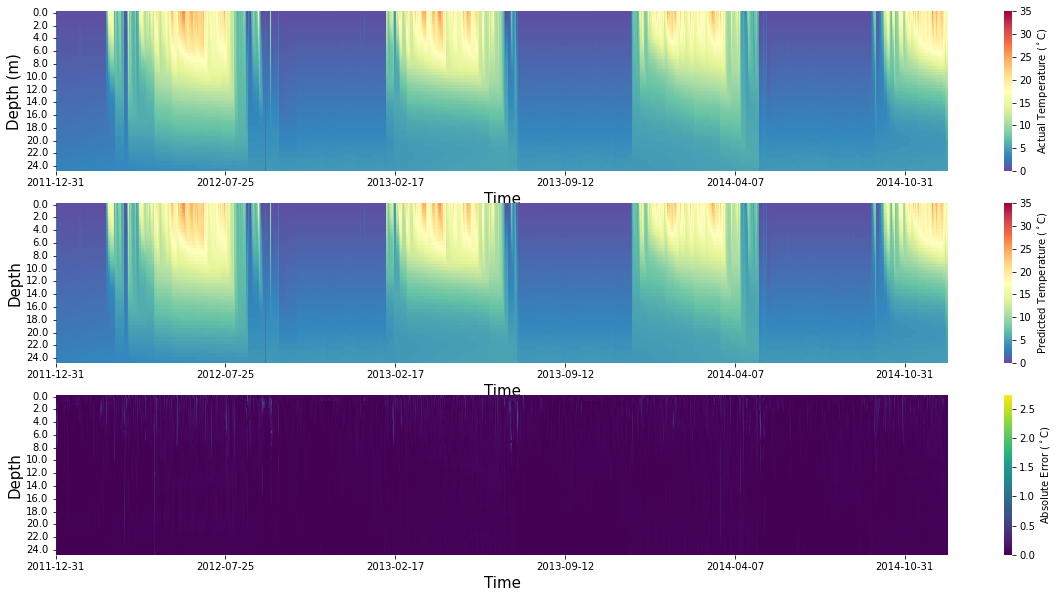

In [24]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

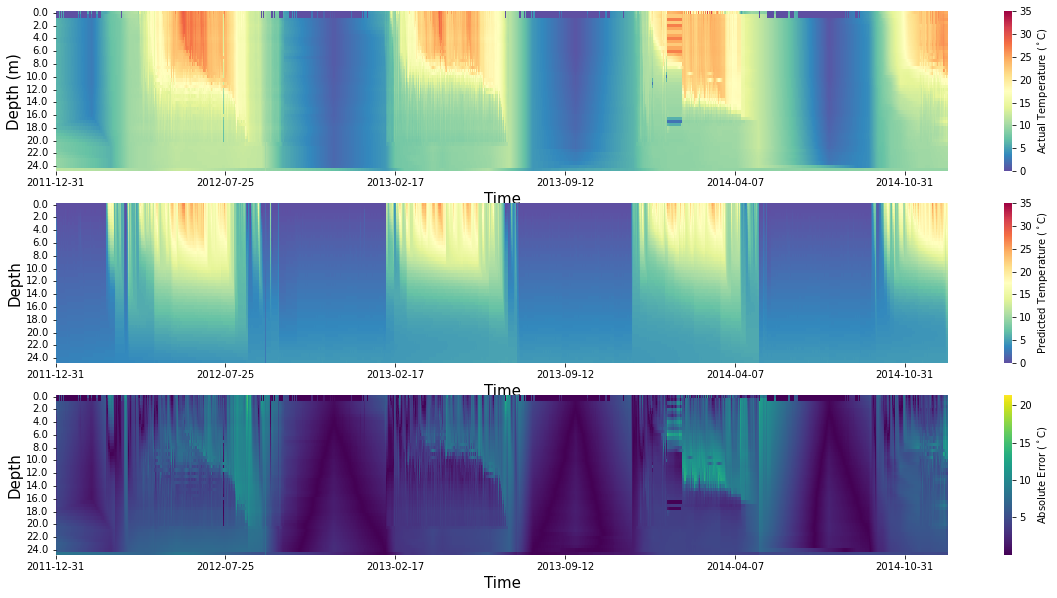

In [25]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [26]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 0.019098237
RMSE of after m4 0.02671519
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 0.028392063
RMSE of after m4 0.03786254
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 0.016677001
RMSE of after m4 0.028951336
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 0.012618293
RMSE of after m4 0.020773193
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 0.013001552
RMSE of after m4 0.021076027
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 0.02228669
RMSE of after m4 0.025835821
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 0.03327698
RMSE of after m4 0.031969585
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 0.023268912
RMSE of after m4 0.027222903
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 0.

RMSE of after m1 0.013494207
RMSE of after m3 0.1238379
RMSE of after m4 0.12246524
RMSE of after m0 0.010086248
RMSE of after m1 0.014489152
RMSE of after m3 0.14237873
RMSE of after m4 0.13773657
RMSE of after m0 0.010526003
RMSE of after m1 0.013280552
RMSE of after m3 0.34221125
RMSE of after m4 0.33810976
RMSE of after m0 0.0064165476
RMSE of after m1 0.007993938
RMSE of after m3 0.05402565
RMSE of after m4 0.045593947
RMSE of after m0 0.008246826
RMSE of after m1 0.009450231
RMSE of after m3 0.043960985
RMSE of after m4 0.053131826
RMSE of after m0 0.00856832
RMSE of after m1 0.008942973
RMSE of after m3 0.02275517
RMSE of after m4 0.032582585
RMSE of after m0 0.0080105355
RMSE of after m1 0.007420443
RMSE of after m3 0.04002306
RMSE of after m4 0.032812037
RMSE of after m0 0.00735115
RMSE of after m1 0.00906626
RMSE of after m3 0.057747774
RMSE of after m4 0.05532177
RMSE of after m0 0.006884833
RMSE of after m1 0.008613156
RMSE of after m3 0.038230482
RMSE of after m4 0.0474753

RMSE of after m3 0.05014928
RMSE of after m4 0.034992844
RMSE of after m0 0.016727151
RMSE of after m1 0.037487112
RMSE of after m3 0.05045363
RMSE of after m4 0.035054408
RMSE of after m0 0.020437868
RMSE of after m1 0.034798715
RMSE of after m3 0.059708357
RMSE of after m4 0.057085257
RMSE of after m0 0.021274403
RMSE of after m1 0.031112265
RMSE of after m3 0.06899061
RMSE of after m4 0.0646406
RMSE of after m0 0.022356205
RMSE of after m1 0.031794883
RMSE of after m3 0.06427806
RMSE of after m4 0.060785994
RMSE of after m0 0.022264007
RMSE of after m1 0.03135108
RMSE of after m3 0.060765065
RMSE of after m4 0.059802394
RMSE of after m0 0.019929828
RMSE of after m1 0.030889409
RMSE of after m3 0.05631297
RMSE of after m4 0.054071844
RMSE of after m0 0.02237051
RMSE of after m1 0.03146648
RMSE of after m3 0.061895438
RMSE of after m4 0.05791336
RMSE of after m0 0.021895729
RMSE of after m1 0.032385953
RMSE of after m3 0.08104441
RMSE of after m4 0.07688014
RMSE of after m0 0.01879709

RMSE of after m1 0.037384342
RMSE of after m3 0.038782332
RMSE of after m4 0.037041586
RMSE of after m0 0.015751312
RMSE of after m1 0.039131418
RMSE of after m3 0.054763496
RMSE of after m4 0.053538132
RMSE of after m0 0.01687112
RMSE of after m1 0.038868997
RMSE of after m3 0.045031074
RMSE of after m4 0.044232924
RMSE of after m0 0.014983046
RMSE of after m1 0.03361482
RMSE of after m3 0.04895919
RMSE of after m4 0.04884175
RMSE of after m0 0.016471757
RMSE of after m1 0.03318227
RMSE of after m3 0.041310098
RMSE of after m4 0.041505095
RMSE of after m0 0.014491249
RMSE of after m1 0.033911772
RMSE of after m3 0.050307337
RMSE of after m4 0.05100042
RMSE of after m0 0.012782771
RMSE of after m1 0.025966147
RMSE of after m3 0.120758966
RMSE of after m4 0.1196774
RMSE of after m0 0.008452922
RMSE of after m1 0.0076276045
RMSE of after m3 0.25663573
RMSE of after m4 0.25830865
RMSE of after m0 0.00939132
RMSE of after m1 0.0076020556
RMSE of after m3 0.07955338
RMSE of after m4 0.08099

RMSE of after m3 0.033993725
RMSE of after m4 0.027124893
RMSE of after m0 0.006852828
RMSE of after m1 0.007532348
RMSE of after m3 0.043904413
RMSE of after m4 0.03844987
RMSE of after m0 0.007878912
RMSE of after m1 0.0067726187
RMSE of after m3 0.024579545
RMSE of after m4 0.02325698
RMSE of after m0 0.008839251
RMSE of after m1 0.006782505
RMSE of after m3 0.01800185
RMSE of after m4 0.01945391
RMSE of after m0 0.008533647
RMSE of after m1 0.00726037
RMSE of after m3 0.015682755
RMSE of after m4 0.015098939
RMSE of after m0 0.008175011
RMSE of after m1 0.007898726
RMSE of after m3 0.017409617
RMSE of after m4 0.017825846
RMSE of after m0 0.006902739
RMSE of after m1 0.008324257
RMSE of after m3 0.01582013
RMSE of after m4 0.015977757
RMSE of after m0 0.006412415
RMSE of after m1 0.008918778
RMSE of after m3 0.017765619
RMSE of after m4 0.016539691
RMSE of after m0 0.0075452384
RMSE of after m1 0.008237378
RMSE of after m3 0.010900977
RMSE of after m4 0.014112015
RMSE of after m0 0

RMSE of after m4 0.025656333
RMSE of after m0 0.011547579
RMSE of after m1 0.017422931
RMSE of after m3 0.054571997
RMSE of after m4 0.057063185
RMSE of after m0 0.011785709
RMSE of after m1 0.01916541
RMSE of after m3 0.025807757
RMSE of after m4 0.036365893
RMSE of after m0 0.010154073
RMSE of after m1 0.018130828
RMSE of after m3 0.012422475
RMSE of after m4 0.023421483
RMSE of after m0 0.01001947
RMSE of after m1 0.018891497
RMSE of after m3 0.018885983
RMSE of after m4 0.0254588
RMSE of after m0 0.011390952
RMSE of after m1 0.02117092
RMSE of after m3 0.025010888
RMSE of after m4 0.0315418
RMSE of after m0 0.011197703
RMSE of after m1 0.019880833
RMSE of after m3 0.030379629
RMSE of after m4 0.04219401
RMSE of after m0 0.0106218625
RMSE of after m1 0.020096842
RMSE of after m3 0.040480606
RMSE of after m4 0.049794234
RMSE of after m0 0.010949679
RMSE of after m1 0.020397726
RMSE of after m3 0.057881795
RMSE of after m4 0.0642082
RMSE of after m0 0.011181671
RMSE of after m1 0.0210

RMSE of after m4 0.047901336
RMSE of after m0 0.012008058
RMSE of after m1 0.017069038
RMSE of after m3 0.05957026
RMSE of after m4 0.06081417
RMSE of after m0 0.008921712
RMSE of after m1 0.013337554
RMSE of after m3 0.10851264
RMSE of after m4 0.095814444
RMSE of after m0 0.0076624337
RMSE of after m1 0.012612576
RMSE of after m3 0.036380943
RMSE of after m4 0.03250496
RMSE of after m0 0.0072549703
RMSE of after m1 0.012961832
RMSE of after m3 0.047913093
RMSE of after m4 0.043797158
RMSE of after m0 0.009103224
RMSE of after m1 0.012746736
RMSE of after m3 0.07517876
RMSE of after m4 0.0707335
RMSE of after m0 0.008878538
RMSE of after m1 0.013399427
RMSE of after m3 0.03759682
RMSE of after m4 0.03553407
RMSE of after m0 0.009287463
RMSE of after m1 0.015470247
RMSE of after m3 0.02660254
RMSE of after m4 0.03567384
RMSE of after m0 0.009328958
RMSE of after m1 0.015242681
RMSE of after m3 0.014676081
RMSE of after m4 0.024337443
RMSE of after m0 0.009002721
RMSE of after m1 0.0159

RMSE of after m1 0.018053144
RMSE of after m3 0.018643277
RMSE of after m4 0.018248575
RMSE of after m0 0.017404107
RMSE of after m1 0.017451309
RMSE of after m3 0.015316908
RMSE of after m4 0.014939869
RMSE of after m0 0.014596269
RMSE of after m1 0.019528314
RMSE of after m3 0.031611778
RMSE of after m4 0.031049939
RMSE of after m0 0.014038491
RMSE of after m1 0.01794402
RMSE of after m3 0.01742255
RMSE of after m4 0.016316174
RMSE of after m0 0.015222443
RMSE of after m1 0.017764198
RMSE of after m3 0.018888347
RMSE of after m4 0.017941207
RMSE of after m0 0.015607198
RMSE of after m1 0.017159326
RMSE of after m3 0.01653943
RMSE of after m4 0.015537089
RMSE of after m0 0.015330799
RMSE of after m1 0.016836561
RMSE of after m3 0.01653978
RMSE of after m4 0.015555482
RMSE of after m0 0.016806316
RMSE of after m1 0.018275991
RMSE of after m3 0.016350523
RMSE of after m4 0.01571979
RMSE of after m0 0.017712705
RMSE of after m1 0.019669158
RMSE of after m3 0.017721554
RMSE of after m4 0.

RMSE of after m1 0.027246295
RMSE of after m3 0.020294428
RMSE of after m4 0.01842587
RMSE of after m0 0.028409822
RMSE of after m1 0.028267369
RMSE of after m3 0.022021743
RMSE of after m4 0.019989341
RMSE of after m0 0.025848227
RMSE of after m1 0.026265947
RMSE of after m3 0.029035931
RMSE of after m4 0.026252007
RMSE of after m0 0.024828149
RMSE of after m1 0.026467362
RMSE of after m3 0.02100676
RMSE of after m4 0.01964672
RMSE of after m0 0.024566019
RMSE of after m1 0.02718351
RMSE of after m3 0.025904529
RMSE of after m4 0.023041928
RMSE of after m0 0.021844607
RMSE of after m1 0.02529575
RMSE of after m3 0.021443812
RMSE of after m4 0.018972753
RMSE of after m0 0.024181297
RMSE of after m1 0.025586048
RMSE of after m3 0.0516663
RMSE of after m4 0.05166846
RMSE of after m0 0.028725252
RMSE of after m1 0.027050585
RMSE of after m3 0.02993934
RMSE of after m4 0.028478775
RMSE of after m0 0.029074952
RMSE of after m1 0.027694253
RMSE of after m3 0.023319544
RMSE of after m4 0.0215

RMSE of after m1 0.0077062263
RMSE of after m3 0.029764123
RMSE of after m4 0.024085138
RMSE of after m0 0.008639388
RMSE of after m1 0.011443795
RMSE of after m3 0.081346385
RMSE of after m4 0.08299244
RMSE of after m0 0.009536335
RMSE of after m1 0.01519691
RMSE of after m3 0.06708643
RMSE of after m4 0.07434335
RMSE of after m0 0.0063060857
RMSE of after m1 0.009314442
RMSE of after m3 0.044299476
RMSE of after m4 0.04396251
RMSE of after m0 0.0085289795
RMSE of after m1 0.008711449
RMSE of after m3 0.042770457
RMSE of after m4 0.03758181
RMSE of after m0 0.008736256
RMSE of after m1 0.0097516095
RMSE of after m3 0.058664136
RMSE of after m4 0.05056386
RMSE of after m0 0.0082190605
RMSE of after m1 0.010800591
RMSE of after m3 0.06393477
RMSE of after m4 0.06604333
RMSE of after m0 0.0075168894
RMSE of after m1 0.01038038
RMSE of after m3 0.046728417
RMSE of after m4 0.049049478
RMSE of after m0 0.0066921776
RMSE of after m1 0.0106602935
RMSE of after m3 0.04793811
RMSE of after m4 

RMSE of after m4 0.018584566
RMSE of after m0 0.008411063
RMSE of after m1 0.013968216
RMSE of after m3 0.037487093
RMSE of after m4 0.03599351
RMSE of after m0 0.00971563
RMSE of after m1 0.015768103
RMSE of after m3 0.032521237
RMSE of after m4 0.034238797
RMSE of after m0 0.011323469
RMSE of after m1 0.017906269
RMSE of after m3 0.017580746
RMSE of after m4 0.0252505
RMSE of after m0 0.011169926
RMSE of after m1 0.018527897
RMSE of after m3 0.016600803
RMSE of after m4 0.023661608
RMSE of after m0 0.010345645
RMSE of after m1 0.018787771
RMSE of after m3 0.01703496
RMSE of after m4 0.025149092
RMSE of after m0 0.009857738
RMSE of after m1 0.018127134
RMSE of after m3 0.011945429
RMSE of after m4 0.021065153
RMSE of after m0 0.009472218
RMSE of after m1 0.017859386
RMSE of after m3 0.016008938
RMSE of after m4 0.028531743
RMSE of after m0 0.009660614
RMSE of after m1 0.018097917
RMSE of after m3 0.019148938
RMSE of after m4 0.027056536
RMSE of after m0 0.009482623
RMSE of after m1 0.

RMSE of after m0 0.009960939
RMSE of after m1 0.016169487
RMSE of after m3 0.020469688
RMSE of after m4 0.031635717
RMSE of after m0 0.010744247
RMSE of after m1 0.017507607
RMSE of after m3 0.029741263
RMSE of after m4 0.035314754
RMSE of after m0 0.011022867
RMSE of after m1 0.015138457
RMSE of after m3 0.058050934
RMSE of after m4 0.045618463
RMSE of after m0 0.009690744
RMSE of after m1 0.015705017
RMSE of after m3 0.032402273
RMSE of after m4 0.032511182
RMSE of after m0 0.010445562
RMSE of after m1 0.017995266
RMSE of after m3 0.029207375
RMSE of after m4 0.032826476
RMSE of after m0 0.010001367
RMSE of after m1 0.01746396
RMSE of after m3 0.027468238
RMSE of after m4 0.03606921
RMSE of after m0 0.00949799
RMSE of after m1 0.015747735
RMSE of after m3 0.047794055
RMSE of after m4 0.06183149
RMSE of after m0 0.009359009
RMSE of after m1 0.013428353
RMSE of after m3 0.054626156
RMSE of after m4 0.04645639
RMSE of after m0 0.008758241
RMSE of after m1 0.013459512
RMSE of after m3 0.

RMSE of after m3 0.057265352
RMSE of after m4 0.056285497
RMSE of after m0 0.015493339
RMSE of after m1 0.018169297
RMSE of after m3 0.027319014
RMSE of after m4 0.02713382
RMSE of after m0 0.0151820695
RMSE of after m1 0.021076469
RMSE of after m3 0.047463987
RMSE of after m4 0.048578583
RMSE of after m0 0.016421856
RMSE of after m1 0.041646767
RMSE of after m3 0.08401673
RMSE of after m4 0.08397255
RMSE of after m0 0.015822817
RMSE of after m1 0.020757953
RMSE of after m3 0.07148361
RMSE of after m4 0.07159441
RMSE of after m0 0.019119844
RMSE of after m1 0.025252035
RMSE of after m3 0.05805646
RMSE of after m4 0.057402562
RMSE of after m0 0.019085782
RMSE of after m1 0.024508202
RMSE of after m3 0.037083052
RMSE of after m4 0.036780104
RMSE of after m0 0.016752798
RMSE of after m1 0.02025835
RMSE of after m3 0.037034363
RMSE of after m4 0.036759634
RMSE of after m0 0.015985588
RMSE of after m1 0.020832816
RMSE of after m3 0.027655436
RMSE of after m4 0.027395496
RMSE of after m0 0.0

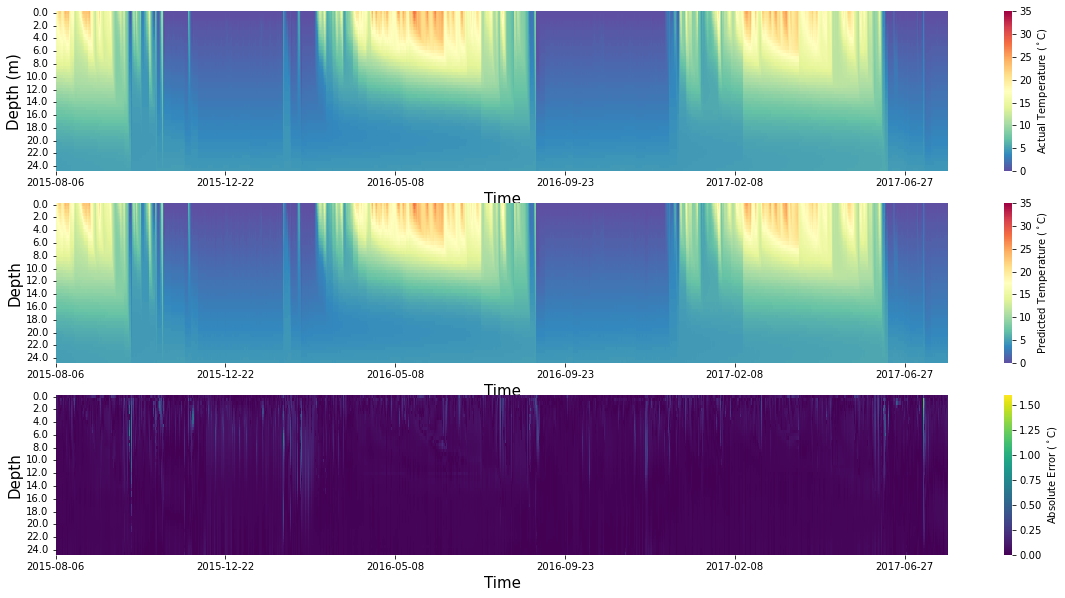

In [27]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

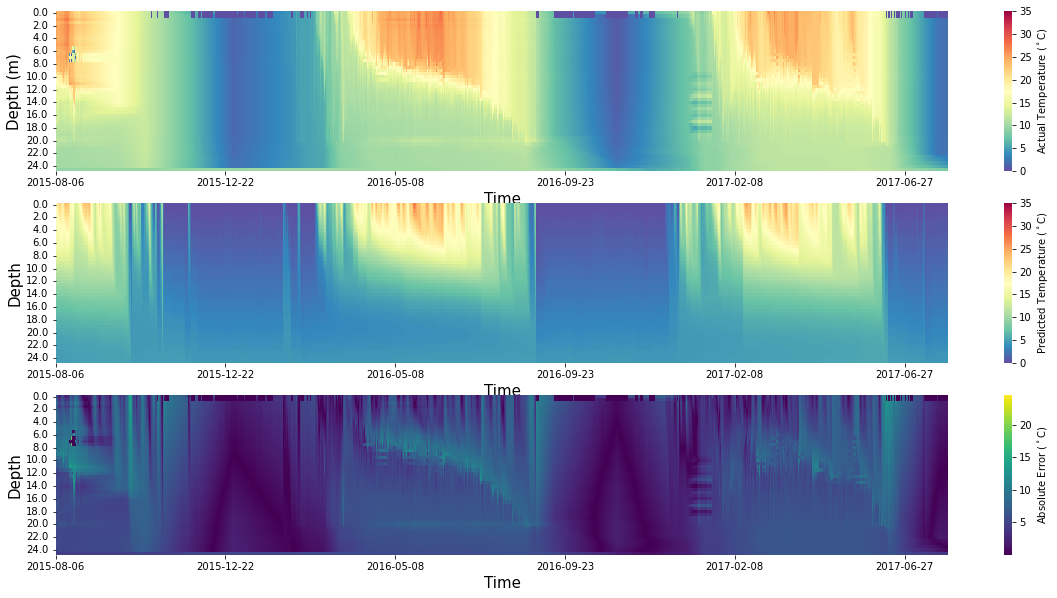

In [28]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [29]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04349529181305193, Train L2 Error: 0.0057276601087314395
Test RMSE: 0.058766599809652265, Train L2 Error: 0.007387817348391442


## Mixing Model

## Convection Model

In [30]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [31]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


In [32]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    times = time_label
    
    print(times)
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    
    #  plt.legend(fontsize='x-large', title_fontsize='40')
    # ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    # ax.set_xticklabels(time_label, rotation=0)
    # new insert
    xticks_ix = np.array(ax.get_xticks()).astype(int)
    
    print(xticks_ix)
    
    time_label = times[xticks_ix]
    
    print(time_label)
    
    nelement = len(time_label)//N_pts
    
    print(nelement)
    
    time_label = time_label[::nelement]
    
    print(time_label)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0, fontsize = 15)
    # old code
    ax.collections[0].colorbar.set_label("Water Temperature ($^\circ$C)", fontsize = 15)
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    
    print(yticks_ix)
    
    # depth_label = depth_steps / 25
    depth_label = yticks_ix / 2
    
    print(depth_label)
    
    nelement = len(depth_label)//5
    
    print(nelement)
    
    depth_label = depth_label[::nelement]
    
    print(depth_label)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_yticklabels(depth_label, rotation=0, fontsize = 15)

    plt.show()

['2015-08-06' '2015-08-06' '2015-08-06' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   281   562   843  1124  1405  1686  1967  2248  2529  2810  3091
  3372  3653  3934  4215  4496  4777  5058  5339  5620  5901  6182  6463
  6744  7025  7306  7587  7868  8149  8430  8711  8992  9273  9554  9835
 10116 10397 10678 10959 11240 11521 11802 12083 12364 12645 12926 13207
 13488 13769 14050 14331 14612 14893 15174 15455 15736 16017 16298 16579
 16860 17141 17422 17703 17984 18265 18546 18827 19108 19389 19670 19951
 20232 20513 20794]
['2015-08-06' '2015-08-17' '2015-08-29' '2015-09-10' '2015-09-21'
 '2015-10-03' '2015-10-15' '2015-10-27' '2015-11-07' '2015-11-19'
 '2015-12-01' '2015-12-12' '2015-12-24' '2016-01-05' '2016-01-16'
 '2016-01-28' '2016-02-09' '2016-02-21' '2016-03-03' '2016-03-15'
 '2016-03-27' '2016-04-07' '2016-04-19' '2016-05-01' '2016-05-13'
 '2016-05-24' '2016-06-05' '2016-06-17' '2016-06-28' '2016-07-10'
 '2016-07-22' '2016-08-02' '2016-08-14' '2016-08-26' '2016-09

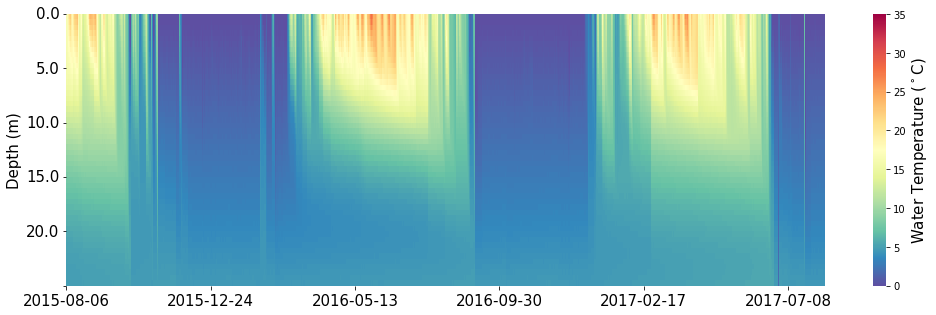

In [33]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5)) # pretraining

['2015-08-06' '2015-08-06' '2015-08-06' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   281   562   843  1124  1405  1686  1967  2248  2529  2810  3091
  3372  3653  3934  4215  4496  4777  5058  5339  5620  5901  6182  6463
  6744  7025  7306  7587  7868  8149  8430  8711  8992  9273  9554  9835
 10116 10397 10678 10959 11240 11521 11802 12083 12364 12645 12926 13207
 13488 13769 14050 14331 14612 14893 15174 15455 15736 16017 16298 16579
 16860 17141 17422 17703 17984 18265 18546 18827 19108 19389 19670 19951
 20232 20513 20794]
['2015-08-06' '2015-08-17' '2015-08-29' '2015-09-10' '2015-09-21'
 '2015-10-03' '2015-10-15' '2015-10-27' '2015-11-07' '2015-11-19'
 '2015-12-01' '2015-12-12' '2015-12-24' '2016-01-05' '2016-01-16'
 '2016-01-28' '2016-02-09' '2016-02-21' '2016-03-03' '2016-03-15'
 '2016-03-27' '2016-04-07' '2016-04-19' '2016-05-01' '2016-05-13'
 '2016-05-24' '2016-06-05' '2016-06-17' '2016-06-28' '2016-07-10'
 '2016-07-22' '2016-08-02' '2016-08-14' '2016-08-26' '2016-09

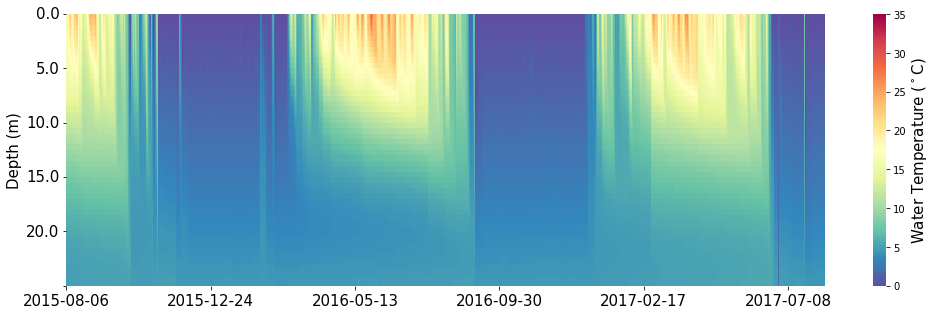

In [34]:
plot_output_test(test_y_true, test_y_obs, depth_steps, test_time, figsize=(17,5)) # process-based

['2015-08-06' '2015-08-06' '2015-08-06' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   281   562   843  1124  1405  1686  1967  2248  2529  2810  3091
  3372  3653  3934  4215  4496  4777  5058  5339  5620  5901  6182  6463
  6744  7025  7306  7587  7868  8149  8430  8711  8992  9273  9554  9835
 10116 10397 10678 10959 11240 11521 11802 12083 12364 12645 12926 13207
 13488 13769 14050 14331 14612 14893 15174 15455 15736 16017 16298 16579
 16860 17141 17422 17703 17984 18265 18546 18827 19108 19389 19670 19951
 20232 20513 20794]
['2015-08-06' '2015-08-17' '2015-08-29' '2015-09-10' '2015-09-21'
 '2015-10-03' '2015-10-15' '2015-10-27' '2015-11-07' '2015-11-19'
 '2015-12-01' '2015-12-12' '2015-12-24' '2016-01-05' '2016-01-16'
 '2016-01-28' '2016-02-09' '2016-02-21' '2016-03-03' '2016-03-15'
 '2016-03-27' '2016-04-07' '2016-04-19' '2016-05-01' '2016-05-13'
 '2016-05-24' '2016-06-05' '2016-06-17' '2016-06-28' '2016-07-10'
 '2016-07-22' '2016-08-02' '2016-08-14' '2016-08-26' '2016-09

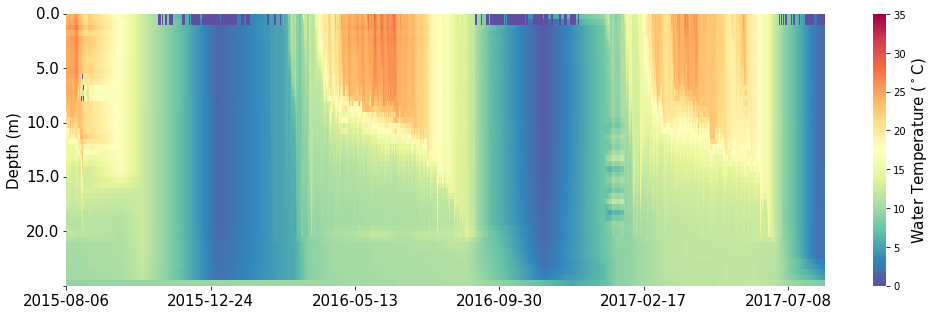

In [35]:
plot_output_test(test_y_obs, test_y_obs, depth_steps, test_time, figsize=(17,5)) # process-based

# Finetuning

# Freeze model weights